Simulating drifts in the gains (deep scans)
====

This notebook treats about the simulation of drits in time in the detector gains. Note that unlike other previous cases, we will inject instrument (white) noise as well.

In [1]:
## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

## Import basic modules and routines
from __future__ import division, absolute_import, print_function

import healpy as hp
import pylab as pl
import numpy as np

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full
from s4cmb.tod import psdts

from s4cmb.systematics import step_function_gen
from s4cmb.systematics import linear_function_gen

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

Flow is the following: sky + instrument + scanning strategy --> map2tod --> create gain drift --> tod2map.

Initialise our instrument, scanning strategy and input maps as seen in the Day 1 lectures. 

In [2]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

## Input maps
nside = 512
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

## Scanning strategy
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

Here is a simple example to illustrate how gains will be changed.
We want to break the timestream every hour (one CES is here 4 hours).
We want to inject \pm 5% drift centered around gain=1.
Currently you have the choice in modeling the drifts as 
step functions or linear functions.
Let's show both on 4 bolometers (2 pairs).
Note that we simulate the gains using generators.
It is particularly useful to save memory (as you do not have 
to store the entire nbolo x nsample in memory) for large runs.
Note that if you do not want to use generators, you can use the 
functions systematics.linear_function and systematics.step_function
instead.

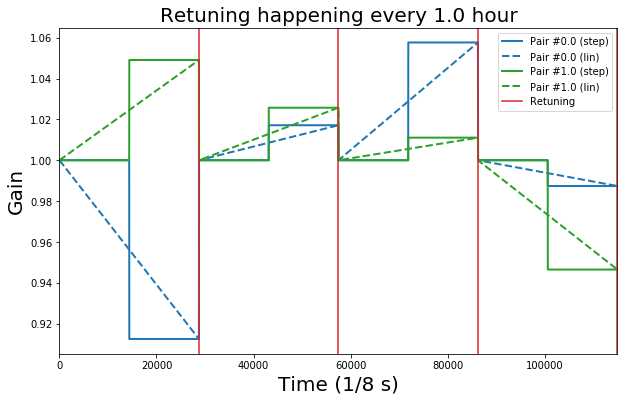

In [3]:
## Length of full timestreams
nts = 115000

## Number of retuning
nbreaks = 4

## Define your generators
gains_step_gen = step_function_gen(
    nsamples=nts, 
    mean=1, 
    std=0.05, 
    nbreaks=nbreaks, 
    seed=100)
gains_lin_gen = linear_function_gen(
    nsamples=nts, 
    mean=1, 
    std=0.05, 
    nbreaks=nbreaks, 
    seed=100)

## Plot gain drifts
pl.figure(figsize=(10, 6))
for i in range(0, 4, 2):
    gains_step = gains_step_gen.next()
    gains_lin = gains_lin_gen.next()
    pl.plot(gains_step[0], color='C{}'.format(i), 
            ls='-', lw=2,
            label='Pair #{} (step)'.format(i/2))
    pl.plot(gains_lin[0], color='C{}'.format(i), 
            ls='--', lw=2,
            label='Pair #{} (lin)'.format(i/2))

pl.xlabel('Time (1/8 s)', fontsize=20)
pl.ylabel('Gain', fontsize=20)
pl.title('Retuning happening every {:.1f} hour'.format(
        len(gains_step[0]) / 3600. / scan.sampling_freq /nbreaks),
        fontsize=20)

## Plot retuning points
count, ini_count = [nts // nbreaks] * 2
while count < nts:
    pl.axvline(count, ls='-', color='C3')
    count += ini_count
pl.axvline(count, ls='-', color='C3', label='Retuning')

pl.xlim(0, nts)
pl.legend()
pl.show()

----------------------------
** Small exercise **

Define your own drift model, and write your own generator.

Help: have a look at routines in s4cmb/systematics.py.

----------------------------

Let's now generate our TOD from our input sky, instrument, and scanning strategy We will use the difference of pairs of detectors to reconstruct the polarisation (no demodulation). We will also inject instrument noise in time-domain.
Once we will have the timestreams, we will reconstruct our maps on a sky patch of width 130 deg at a resolution nside = 512.

In [4]:
## Time-domain Noise level in [u]K.sqrt(s) for the whole array for one CES.
## Careful the units has to be the same as
## the input map! Note also that it corresponds to the polarisation level.
## This corresponds roughly to 10 uk.arcmin:
array_noise_level = 4.5

## Freeze initial seed, and define seeds for all scans
state_for_gain = np.random.RandomState(0)
seeds_for_gain = state_for_gain.randint(0, 1e6, scan.nces)

state_for_noise = np.random.RandomState(3)
seeds_for_noise = state_for_noise.randint(0, 1e6, scan.nces)

## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by ot storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Just for visualisation we also compute the result without contamination
    tod_perfect = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ########################################################################
    ## Make new gain with 5% drift centered around 1, retuned every hour. ##
    ########################################################################
    new_gains_gen = linear_function_gen(tod.nsamples, 
                                        mean=1., 
                                        std=0.05, 
                                        nbreaks=4, 
                                        seed=seeds_for_gain[CESnumber])
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        
        sky_perfect = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for pair in tqdm(tod.pair_list):
        ## Update the gains
        tod.set_detector_gains_perpair(new_gains=new_gains_gen.next())
        d = np.array([tod.map2tod(det) for det in pair])
        
        d_perfect = np.array([tod_perfect.map2tod(det) for det in pair])
        
        ## Project TOD to maps
        tod.tod2map(d, sky)
        tod_perfect.tod2map(d_perfect, sky_perfect)

100%|██████████| 64/64 [00:21<00:00,  2.97it/s]


let's have a look at one TOD:

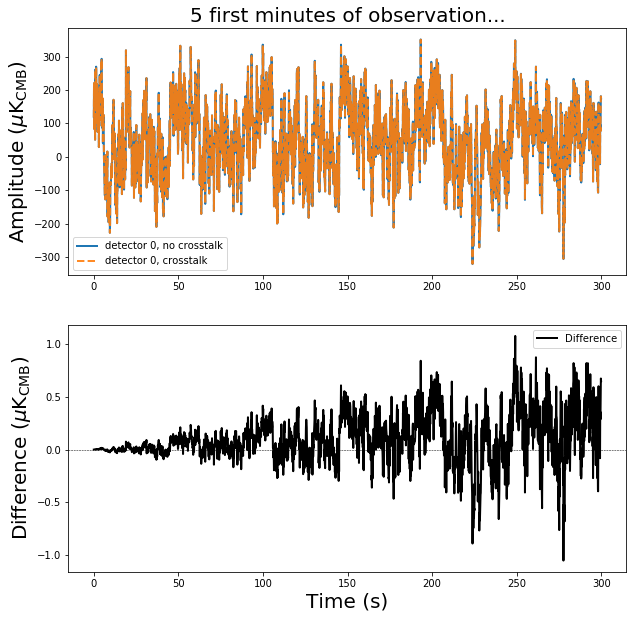

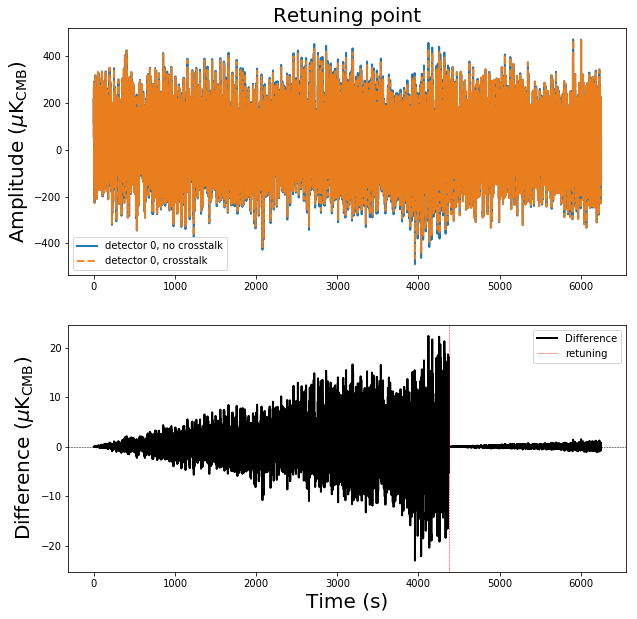

In [5]:
stop = 2400
xaxis = [t/scan.sampling_freq for t in range(0, stop)]

fig, ax = pl.subplots(2, 1, figsize=(10, 10))

ax[0].plot(xaxis, d[0][0:stop], label='detector 0, no crosstalk', lw=2)
ax[0].plot(xaxis, d_perfect[0][0:stop], 
           label='detector 0, crosstalk', 
           ls='--', lw=2, alpha=0.9)
ax[0].legend()
ax[0].set_ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
ax[0].set_title('5 first minutes of observation...', fontsize=20)

ax[1].plot(xaxis, d[0][0:stop] - d_perfect[0][0:stop], 
           label='Difference', lw=2, color='black')
ax[1].axhline(0, ls='--', color='black', lw=0.5)
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel('Difference ($\mu$K$_{\\rm CMB}$)', fontsize=20)

pl.legend()
pl.show()

stop = 50000
xaxis = [t/scan.sampling_freq for t in range(0, stop)]

fig, ax = pl.subplots(2, 1, figsize=(10, 10))

ax[0].plot(xaxis, d[0][0:stop], label='detector 0, no crosstalk', lw=2)
ax[0].plot(xaxis, d_perfect[0][0:stop], 
           label='detector 0, crosstalk', 
           ls='--', lw=2, alpha=0.9)
ax[0].legend()
ax[0].set_ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
ax[0].set_title('Retuning point', fontsize=20)

ax[1].plot(xaxis, d[0][0:stop] - d_perfect[0][0:stop], 
           label='Difference', lw=2, color='black')
ax[1].axhline(0, ls='--', color='black', lw=0.5)
ax[1].axvline(len(d[0]) / 4 / scan.sampling_freq, ls='--', 
              color='red', lw=0.5, label='retuning')
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel('Difference ($\mu$K$_{\\rm CMB}$)', fontsize=20)

pl.legend()
pl.show()

Let's also have a look at the PSD for 5 minutes of observation - all detectors. Note that the high frequency are mostly white, and the rise for low freq is only due to CMB (no 1/f noise here):

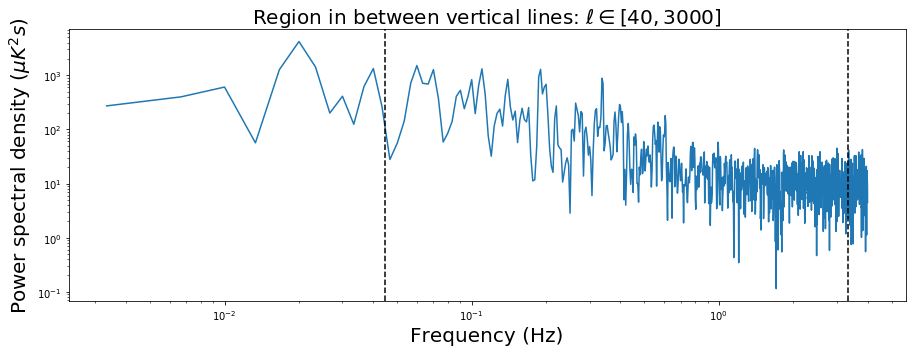

In [6]:
def ell2freq(ell, vscan):
    """
    Rough scaling between timestream frequency and multipole \ell
    given the scan velocity (az speed basically) in deg/s.
    """
    return ell * vscan / 360.

nts = 2400
for pos, ts in enumerate(d):
    fs, psd = psdts(ts[0:nts] + 0.0, sample_rate=scan.sampling_freq)
    if pos == 0:
        psds = np.zeros_like(psd)
    psds += psd
psds /= (2*tod.npair)

fig = pl.figure(figsize=(15, 5))
pl.loglog(fs, psds)
pl.axvline(ell2freq(40, vscan=scan.sky_speed), 
           ls='--', color='black')
pl.axvline(ell2freq(3000, vscan=scan.sky_speed), 
           ls='--', color='black')
pl.title('Region in between vertical lines: $\ell \in [40, 3000]$', fontsize=20)
pl.xlabel('Frequency (Hz)', fontsize=20)
pl.ylabel('Power spectral density ($\mu K^2 s$)', fontsize=20)
pl.show()

Let's check the output maps

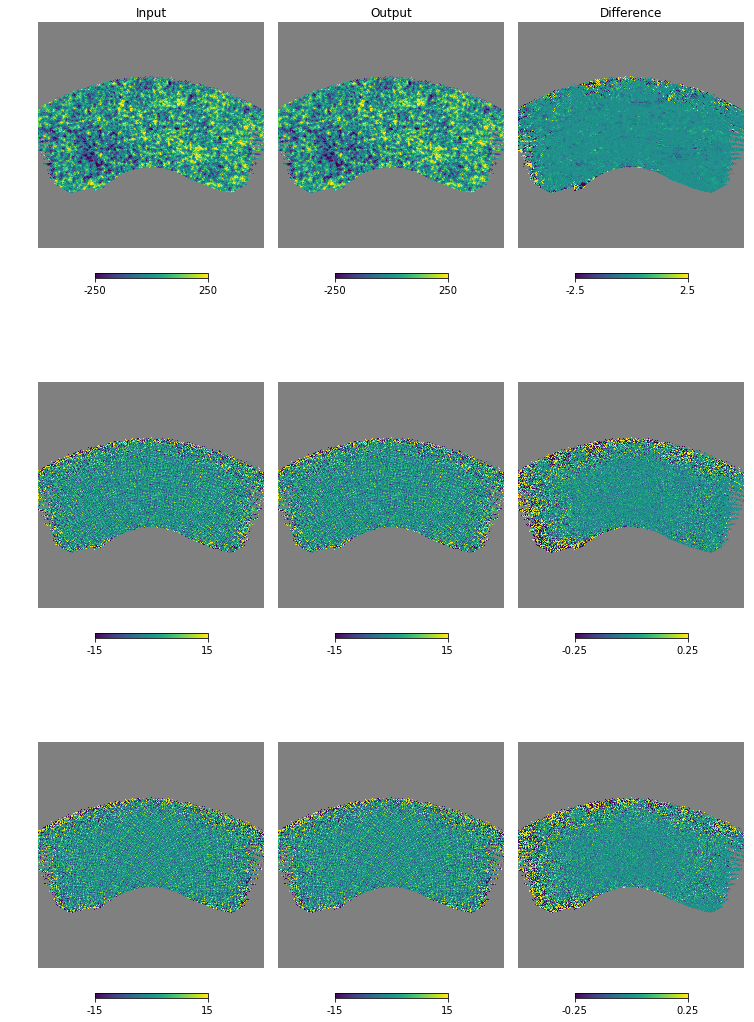

In [8]:
xsize = 700
fig = pl.figure(figsize=(10, 15))

nhit = partial2full(
    sky.nhit, 
    sky.obspix, 
    sky.nside, fill_with=0.0)

## Temperature
sky_out = partial2full(
    sky.get_I(), 
    sky.obspix, 
    sky.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_I(), 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 1
sky_out[mask] = np.nan
sky_out_perfect[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input', notext=True, min=-250, max=250)
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Output', notext=True, min=-250, max=250)
hp.gnomview(sky_out_perfect - sky_out, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=333, 
            title='Difference', notext=True, min=-2.5, max=2.5)

## Stokes Q
sky_out = partial2full(
    sky.get_QU()[0], 
    sky.obspix, 
    sky.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_QU()[0], 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 10
sky_out[mask] = np.nan
sky_out_perfect[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_perfect - sky_out, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=336, 
            notext=True, title='', min=-0.25, max=0.25)

## Stokes U
sky_out = partial2full(
    sky.get_QU()[1], 
    sky.obspix, 
    sky.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_QU()[1], 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 10
sky_out[mask] = np.nan
sky_out_perfect[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_perfect - sky_out, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=339, 
            notext=True, title='', min=-0.25, max=0.25)
pl.show()